<a href="https://colab.research.google.com/github/FyodorPi/density-scatter-plot/blob/main/density_scatter_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pandas.io.excel import ExcelWriter
import numpy as np
import os
import glob
import re
import statistics as stat
import math
# import jpype
# jpype.startJVM()
# import asposecells
# from asposecells.api import Workbook as Workbook1
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# from skspatial.objects import Points
# from skspatial.objects import Line
# from skspatial.objects import Plane
# from skspatial.plotting import plot_3d
# import ezodf

import openpyxl
from openpyxl import load_workbook, Workbook
from openpyxl.styles import Color, PatternFill, Font, Border, Side
from openpyxl.styles.differential import DifferentialStyle
from openpyxl.formatting.rule import ColorScaleRule, CellIsRule, FormulaRule
from openpyxl.chart import BarChart, LineChart, ScatterChart, Reference, Series
from openpyxl.worksheet.table import Table, TableStyleInfo
from openpyxl.drawing.image import Image
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.stats import gaussian_kde
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# product = ('arm_kanat', 'Арматурный канат')
# product = ('prgon', 'Противоугон')
# product = ('p_prov', 'Пружинная проволока')
product = ('STAP_prov', 'Проволока СТАП')

os.chdir(f"/content/drive/My Drive/1Статистика/Статистика/oracle_{product[0]}")

xl_files = glob.glob('*')

In [ ]:
result = pd.DataFrame()
probe = pd.DataFrame()
vhod = pd.DataFrame()
# plavki = pd.DataFrame()

# Цикл по файлам
for xl_file in xl_files:
    xl_file_obj = pd.ExcelFile(xl_file)

    for sheet_name in xl_file_obj.sheet_names:
        results = 'Результаты'
        probes = 'Пробы'
        vhcontrol = 'Вх.контроль'

        if sheet_name.startswith(probes):
            data = pd.read_excel(xl_file_obj,
                                header=[0],
                                sheet_name=sheet_name)
            probe = pd.concat([probe, data], sort=False)
            # combined2["Диаметр"] = combined2["Описание позиции"].str.extract('([-\s]\d+(?:,\d+)?[-\s]?)', expand=False)
            probe["Диаметр"] = probe["Описание позиции"].str.extract('([-\s]\d+,\d+[-\s]?)', expand=False)
            probe['Диаметр'] = probe['Диаметр'].str.replace(',', '.')
            probe['Диаметр'] = probe['Диаметр'].str.replace('-', '')
            probe = probe.astype({'Диаметр': np.float64})
            probe['Марка-НД'] = probe['Описание позиции'].str.replace('Проволока ', '')

        if sheet_name.startswith(results):
            data = pd.read_excel(xl_file_obj,
                                # skiprows=15,
                                header=[0],
                                sheet_name=sheet_name)
            data = data.drop(labels = [0],axis = 0)
            pd.set_option('display.max_columns', None)
            data=data.rename(columns = {'Unnamed: 10':'Минимум_норм', 'Unnamed: 11':'Максимум_норм'})
            data = data.astype({'Минимум': np.float64})
            data = data.astype({'Максимум': np.float64})
            data['mean'] = data[['Минимум', 'Максимум']].mean(axis= 1 )
            result = pd.concat([result, data], sort=False)

        if sheet_name.startswith(vhcontrol):
            data = pd.read_excel(xl_file_obj,
                                header=[0],
                                sheet_name=sheet_name)
            data = data.drop(labels = [0],axis = 0)
            vhod = pd.concat([vhod, data], sort=False)

# print(probe)
# print(result)
# print(vhod)

# Преобразование кодов и классов проверки
result['Код проверки'] = result['Код проверки'].str.replace('|', '-').str.replace('/', '-').str.replace('-М', '')
result['Класс проверки (код)'] = result['Класс проверки (код)'].str.replace('|', '-').str.replace('М-', '')
# print(result)

# Удаление строк с пустыми значениями в поле 'mean'
result = result.dropna (subset=['mean'])
# print(result)

# Создание списка из уникальных кодов проверки
char_got = result['Код проверки'].unique ()

# Создание датафрейма из уникальных проб
proby = result['Проба'].unique ()
proby = pd.DataFrame(proby, columns=['Проба'])
# print(proby)

# gotov = pd.DataFrame()

# Транспонирование таблицы результатов
for charact in char_got:
    gotov = result.loc[result["Код проверки"] == charact]
    gotov = gotov[['Проба','mean']].copy ()
    gotov = gotov.rename(columns={'mean': str(charact)})
    proby=pd.merge(proby, gotov, on=('Проба'), how ='left')
del proby['Диаметр']
# print(proby)

probe = probe[[
    'Проба',
    'Плавка',
    'Диаметр',
    'Марка-НД',
    'Описание марки',
    ]].copy ()
# probe = probe.loc[probe["Описание марки"] == '80-Ф']
del probe['Описание марки']
probe = probe.dropna (subset=['Плавка', 'Диаметр'])
# plavki = plavki.dropna (subset=['Диаметр'])
# print(probe)

# Объединение матриц готовой продукции
df=pd.merge(proby, probe, on=('Проба'), how ='left')
df = df.dropna (subset=['Плавка'])
# print(df)

# Удаление строк с нечисловыми параметрами подката
filter_regex = '[a-zA-ZА-Яа-я]'
vhod = vhod.astype({'Данные СК поставщика': str})
vhod = vhod[~vhod['Данные СК поставщика'].str.contains(filter_regex, flags=re.IGNORECASE, regex=True)]
# print(vhod)

# Создание столбца "Вх. диаметр"
vhod["Вх. диаметр"] = vhod["Описание"].str.extract('(-\s\d+(?:.\d+)?)', expand=False)
vhod['Вх. диаметр'] = vhod['Вх. диаметр'].str.replace('- ', '')
vhod['Вх. диаметр'] = vhod['Вх. диаметр'].str.replace(',', '.')
vhod = vhod.astype({'Вх. диаметр': np.float64})

# Создание датафрейма из уникальных плавок
plavki = vhod['Плавка'].unique ()
plavki = pd.DataFrame(plavki, columns=['Плавка'])
plavki = vhod.groupby(['Плавка'])['Вх. диаметр'].agg(["mean"])
plavki = plavki.rename(columns={'mean': 'Вх. диаметр'})
plavki = plavki.dropna (subset=['Вх. диаметр'])
# print(plavki)

# Транспонировние таблицы подката
podkat = pd.DataFrame()
char_vh = vhod['Показатель'].unique ()
for charact in char_vh:
    podkat = vhod.loc[vhod["Показатель"] == charact]
    podkat = podkat.astype({'Данные СК поставщика': np.float64})
    podkat = podkat.groupby(['Плавка'])['Данные СК поставщика'].agg(["mean"])
    podkat = podkat.rename(columns={'mean': 'Вх. ' + str(charact)})
    plavki=pd.merge(plavki, podkat, on=('Плавка'), how ='left')
# print(plavki)

# Объединение матриц готовой продукции и подката
df=pd.merge(df, plavki, on=('Плавка'), how ='left')
# df=pd.merge(combined4, df, on=('Плавка'), how ='left')
# print(df)

# Расчет обжатия
df['Обжатие'] = 100 * (1 - (df['Диаметр'] / df['Вх. диаметр']) ** 2)
df = df[(df['Обжатие'] < 150) & (df['Обжатие'] > 10)]
# print(df[['Обжатие']])

# df = df.rename(columns={'Число_скручиваний': 'Число_скруч.'})
# print(df)

del df['Марка-НД']

# Сгруппировать поплавочно
df = df.groupby(['Плавка']).agg(["mean"])
col1 = []
for col in df.columns:
    col1.append(col[0])
# col1 = [x.replace('Вх. ', '') for x in col1]
df.columns = col1
# print(df)

df = df.rename(columns={
    'Вх. Al': 'Al',
    'Вх. N': 'N',
    'Вх. As': 'As',
    'Вх. C': 'C',
    'Вх. Cr': 'Cr',
    'Вх. Cu': 'Cu',
    'Вх. Mn': 'Mn',
    'Вх. Ni': 'Ni',
    'Вх. P': 'P',
    'Вх. S': 'S',
    'Вх. Si': 'Si',
    'Вх. Ti': 'Ti',
    'Вх. V': 'V',
    }, errors="ignore")


df.drop ([
            'Плавка',
            'Проба',
            # 'Описание',
            'Обезугл_слой',
            'Диаметр',
            'Вх. диаметр',
            'Плотн_цинк',
            # 'Число_погружений',
            # 'Al',
            # 'N',
            # 'As',
            # 'C',
            # 'Cr',
            # 'Cu',
            # 'Mn',
            'Ni',
            # 'P',
            'S',
            'Si',
            # 'Ti',
            # 'V',
            'Число_погружений',
            'Относит_удлинение',
            'Напр_при_1_удл',
            'Вх. Масса_окалины',
            'Вх. НЗД_max',
            'Вх. НЗД_min',
            'Вх. Нвкл_д_ОС_max',
            'Вх. Нвкл_д_ОС_ср',
            'Вх. Нвкл_д_ОТ_max',
            'Вх. Нвкл_д_ОТ_ср',
            'Вх. Нвкл_д_С_max',
            'Вх. Нвкл_д_С_ср',
            'Вх. Нвкл_д_СН_max',
            'Вх. Нвкл_д_СН_ср',
            'Вх. Нвкл_д_СП_max',
            'Вх. Нвкл_д_СП_ср',
            'Вх. Нвкл_д_СХ_max',
            'Вх. Нвкл_д_СХ_ср',
            'Вх. Об_слой',
            'Вх. Перл_ПЛ_1_2б',
            'Удерж_способ',
            'Вх. Длина',
            'Вх. Ликв_квадрат',
            'Вх. Точечн_неодн',
            'Вх. Центр_порист',
            'Вх. Подусад_ликв',
            'Вх. Перл_ПЛ_1б',
            'Z_сечения',
            'Вх. Обезугл_слой',
        ], axis= 1 , inplace= True, errors='ignore'  )

# df.isnull().sum()
# df.dropna(axis=1, thresh= 100, inplace=True)

# print(df)

df.dropna(axis=1, thresh= 50, inplace=True)

# print(df)

df.dropna(axis=0, inplace=True)

print(df)

# df.dropna(axis=0, inplace=True)

# print(df)

             Врм_сопр      C       Cr    Cu    Mn      P  Вх. Врм_сопр  \
Плавка                                                                   
890017.0  1699.314607  0.785  0.03125  0.03  0.46  0.010   1127.625000   
890018.0  1724.333333  0.780  0.03000  0.02  0.46  0.008   1100.000000   
890023.0  1577.986667  0.770  0.05000  0.01  0.47  0.009   1114.000000   
890024.0  1563.750000  0.790  0.03000  0.01  0.47  0.005   1110.000000   
890026.0  1581.500000  0.810  0.02000  0.01  0.43  0.005   1077.500000   
...               ...    ...      ...   ...   ...    ...           ...   
895847.0  1713.448276  0.770  0.05000  0.02  0.48  0.014   1170.000000   
895915.0  1631.857143  0.700  0.03000  0.02  0.45  0.005   1055.000000   
895982.0  1619.600000  0.710  0.03000  0.02  0.44  0.012   1000.000000   
895984.0  1541.320755  0.710  0.03000  0.02  0.45  0.015    995.714286   
895985.0  1656.428571  0.700  0.04000  0.02  0.47  0.023   1020.000000   

          Вх. Дельта_10  Вх. Отн_суже

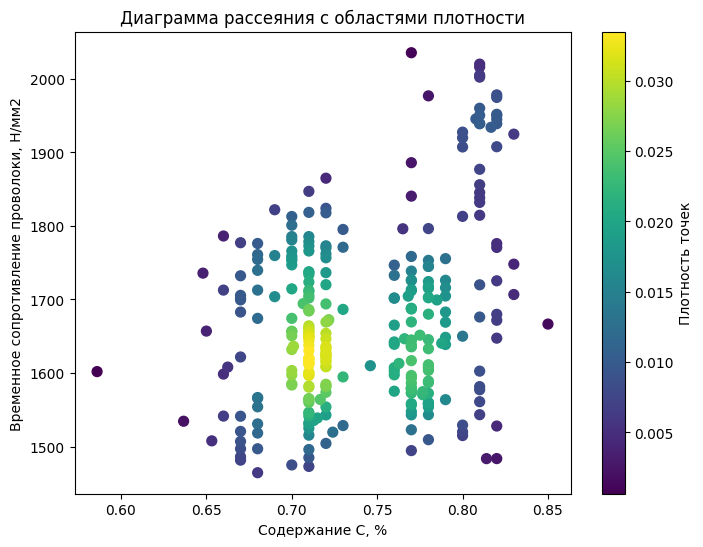

In [ ]:
# Диаграмма рассеяния с областями плотности

x = df['C'].tolist()
y = df['Врм_сопр'].tolist()

data = pd.DataFrame({'X': x, 'Y': y})

# Вычисляем плотность для каждой точки
xy = np.vstack([data['X'], data['Y']])
z = gaussian_kde(xy)(xy)

# Сортируем точки по плотности для корректного отображения
idx = z.argsort()
x, y, z = data['X'][idx], data['Y'][idx], z[idx]

# Построение графика
plt.figure(figsize=(8,6))
scatter = plt.scatter(x, y, c=z, s=50, cmap='viridis')
plt.colorbar(scatter, label='Плотность точек')
plt.xlabel('Содержание C, %')
plt.ylabel('Временное сопротивление проволоки, Н/мм2')
plt.title('Диаграмма рассеяния с областями плотности')
plt.show()

In [ ]:
os.chdir('..')
os.chdir(f"result_{product[0]}")

# column_names = df.columns.tolist()
# print(column_names)

# Указать writer библиотеки
writer=pd.ExcelWriter(product[1] + ' (МО)' + '.xlsx', engine='openpyxl')
wb  = writer.book

#Тепловая карта
fig, ax = plt.subplots(figsize=(9, 9))
sns.set(font_scale=0.6)
hm = sns.heatmap(df.corr(),
                 cbar=True,
                 annot=True,
                 fmt='.2g',
                 )
plt.tight_layout()
hm.figure.savefig('hm.png')

ws1 = wb.create_sheet('Корр. матрица')
# получаем объект изображения
hm = Image("hm.png")
hm.height = 600
hm.width = 800
# добавляем изображение
ws1.add_image(hm, "A1")

# Создание датасета корреляций
df_new = pd.DataFrame(df.corr().values, columns=df.corr().columns, index=df.corr().index)
# df_new.columns =
df_new = df_new.sort_values(by='Врм_сопр',ascending=True)
print(df_new.iloc[:-1,0])

In [ ]:
# Диаграмма влияния
# plt.figure(figsize=(20,5))
fig, ax = plt.subplots()
x = df_new.iloc[:-1,0].index
y = df_new.iloc[:-1,0]
# ax.bar(x, y, color="C0")
color_rectangle = np.random.rand(7, 3)    # RGB
bars = ax.bar(x, y, color=color_rectangle, label=x) # получаем график в переменную
ax.axes.xaxis.set_visible(False)
ax.set_facecolor('seashell')
ax.legend(bars, x, loc='upper left') # указываем хендлеры и метки к ним

ax.tick_params(axis="y", colors="C0")
plt.title('Врм_сопр')
plt.tight_layout()
fig.figure.savefig('corrs.png')

ws2 = wb.create_sheet('Диаграмма влияния')

# получаем объект изображения
corrs = Image('corrs.png')

corrs.height = 500
corrs.width = 500

ws2.add_image(corrs, "A1")

In [ ]:
# Радарная диаграмма

df_radar = pd.DataFrame(dict(
    r=df_new.iloc[:-1,0],
    theta=df_new.iloc[:-1,0].index))
fig = px.line_polar(df_radar, r='r', theta='theta', line_close=True)
plt.title('Врм_сопр')
fig.write_image("radar.png")
ws3 = wb.create_sheet('Радарная диаграмма')

# получаем объект изображения
radar = Image('radar.png')

ws3.add_image(radar, "A1")

In [ ]:
#Парный график
plt.figure(figsize=(10,10), dpi= 80)
sns.set_theme(font_scale=1.5)
pp = sns.pairplot(
        df,
        kind="scatter",
        # hue="species",
        plot_kws=dict(s=100, edgecolor="white", linewidth=2.5),
        )
pp.figure.savefig('pp.png')
ws4 = wb.create_sheet('Парный график')
pp = Image("pp.png")
pp.height = 600
pp.width = 800
ws4.add_image(pp, "A1")

In [ ]:
n_col = len(df.columns)
n_y = 4 #Число зависимых переменных
# print(list(range(n_y)))

yy = df.drop(df.columns [[x for x in range(n_y, n_col)]], axis=1)
# XX = df.drop(df.columns [[0:n_y]], axis=1)
XX = df.drop(df.columns [list(range(n_y))], axis=1)

for name, values in yy.items ():
    y = values
    X = XX
    # name = name[0]

    for n in [1,2]:

        # ws1 = wb.create_sheet(str(name + (str(n),)))
        ws = wb.create_sheet(name + str(n))

        ws.cell(row=1,column=1).value = 'Результаты линейной регрессии'
        ws['A1'].font = Font(bold=True)

        #add constant to predictor variables
        X = sm.add_constant (X)
        # print(X)

        #fit linear regression model
        model = sm. OLS (y, X). fit ()

        #view model summary
        # print(model. summary ())
        data0 = (model. summary2 ().tables[0])
        data1 = (model. summary2 ().tables[1])
        data2 = (model. summary2 ().tables[2])

        data_nezn = data1.loc[data1["P>|t|"] > 0.05]
        # print(type(list(data_nezn.index)))

        data0.to_excel(writer, sheet_name = str(name + str(n)), startrow=1 , startcol=0, header = None, index= False)
        data1.to_excel(writer, sheet_name = str(name + str(n)), startrow=2 , startcol=7)
        data2.to_excel(writer, sheet_name = str(name + str(n)), startrow=10 , startcol=0, header = None, index= False)

        ws.column_dimensions['A'].width = 20
        ws.column_dimensions['B'].width = 15
        ws.column_dimensions['C'].width = 15
        ws.column_dimensions['D'].width = 12
        ws.column_dimensions['E'].width = 20
        ws.column_dimensions['H'].width = 20

        formula = '=I4'
        for i in range(1, len(X.columns)):
            ws.cell(row=i+4,column=5).value = X.columns[i]
            ws.cell(row=i+4,column=6).value = X.iloc[0,i]
            formula = formula + '+I' + str(i+4) + '*F' +  str(i+4)

        ws.cell(row=len(X.columns)+4,column=5).value = name
        ws.cell(row=len(X.columns)+4,column=6).value = formula
        ws.cell(row=len(X.columns)+4,column=5).font = Font(bold=True)
        ws.cell(row=len(X.columns)+4,column=6).font = Font(bold=True)

        thins = Side(border_style="medium", color="0000ff")

        for r, row in enumerate(range(5, len(X.columns)+4), start=1):
            ws.cell(row=row, column=6).border = Border(top=thins, bottom=thins, left=thins, right=thins)
            ws.cell(row=row,column=5).font = Font(bold=True)

        X=X.drop(list(data_nezn.index), axis= 1)

wb.save(product[1] + ' (МО)' + '.xlsx')
